In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
import numpy as np
import rasterio
from rasterio.mask import mask
from matplotlib.colors import ListedColormap

In [2]:
counties_gpd = gpd.read_file("counties.geojson")
counties_gpd.head(5)

,NAME,POP100,geometry
0,Racine County,195408,"POLYGON ((-88.07073 42.66976, -88.06897 42.669..."
1,Clark County,34690,"POLYGON ((-90.55875 44.42221, -90.53398 44.422..."
2,Wood County,74749,"POLYGON ((-89.72464 44.33712, -89.72460 44.338..."
3,Rusk County,14755,"POLYGON ((-90.92517 45.37935, -90.92515 45.379..."
4,Ozaukee County,86395,"POLYGON ((-87.89269 43.19202, -87.89265 43.192..."


In [3]:
#Q1
len(counties_gpd)

72

<Axes: >

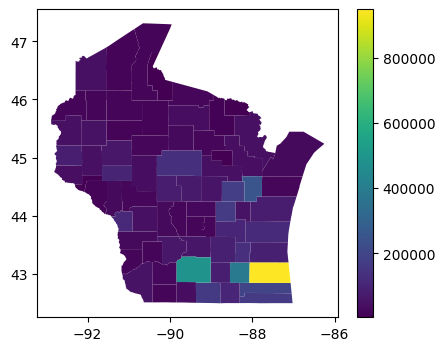

In [4]:
#Q2
fig, ax = plt.subplots(1,1)
fig.set_size_inches(5,4)
counties_gpd.plot('POP100', ax=ax, legend=True)

In [5]:
# add an AREALAND column to your GeoDataFrame of counties so that we can try to predict population based on area. get area from counties_tracts.db
with sqlite3.connect("counties_tracts.db") as conn:
    counties_gpd['AREALAND'] = pd.read_sql("""Select Arealand From counties""", conn)['AREALAND']
counties_gpd.head(3)

# Pass random_state=320 as a parameter so that it shuffles the same way.
# Pass test_size=0.25 to make the test set be one quarter of the original data and the other three quarters remaining in the training set.
train, test = train_test_split(counties_gpd,random_state=320,test_size=0.25)

In [6]:
#Q3
list(test['NAME'])

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

In [7]:
#Q4
# Let's use the train and the test data
m1 = LinearRegression()
# Fit using training data
m1.fit(train[["AREALAND"]], train["POP100"])
# Predict using test data
predictions = m1.predict(test[["AREALAND"]])
# We can use score directly as it automatically invokes predict
m1.score(test[["AREALAND"]], test["POP100"])

0.022002661530554857

In [8]:
# https://tigerweb.geo.census.gov/tigerwebmain/TIGERweb_attribute_glossary.html
# AREALAND is in square meters. 1000000 sq m * 2.59 sq km = 1 sq mi
q5_predict = 300 * 2.59 * 1000000
q5_predict = m1.predict([[q5_predict]])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [9]:
#Q5
float(q5_predict[0])

89016.40396725974

In [10]:
# PART 2 Predicting Population using Housing Units

In [11]:
counties_gpd.head(5)

,NAME,POP100,geometry,AREALAND
0,Racine County,195408,"POLYGON ((-88.07073 42.66976, -88.06897 42.669...",861533739
1,Clark County,34690,"POLYGON ((-90.55875 44.42221, -90.53398 44.422...",3133378070
2,Wood County,74749,"POLYGON ((-89.72464 44.33712, -89.72460 44.338...",2054044751
3,Rusk County,14755,"POLYGON ((-90.92517 45.37935, -90.92515 45.379...",2366092584
4,Ozaukee County,86395,"POLYGON ((-87.89269 43.19202, -87.89265 43.192...",603514413


In [12]:
with sqlite3.connect("counties_tracts.db") as conn:
    query = """
    Select NAME, counties.COUNTY, tracts.HU100 From counties
    Inner Join (Select COUNTY, SUM(HU100) as HU100 From tracts Group By COUNTY) as tracts
        On counties.COUNTY = tracts.COUNTY
    """
    hu100_df = pd.read_sql(query, conn)[['NAME', 'HU100']]
counties_gpd = counties_gpd.merge(hu100_df, how='left', on='NAME')
counties_gpd.head(3)

,NAME,POP100,geometry,AREALAND,HU100
0,Racine County,195408,"POLYGON ((-88.07073 42.66976, -88.06897 42.669...",861533739,82164
1,Clark County,34690,"POLYGON ((-90.55875 44.42221, -90.53398 44.422...",3133378070,15076
2,Wood County,74749,"POLYGON ((-89.72464 44.33712, -89.72460 44.338...",2054044751,34088


In [13]:
# Pass random_state=320 as a parameter so that it shuffles the same way.
# Pass test_size=0.25 to make the test set be one quarter of the original data and the other three quarters remaining in the training set.
train, test = train_test_split(counties_gpd,random_state=320,test_size=0.25)

In [14]:
#Q6
list(test['NAME'])

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

In [15]:
#Q7
dict(test[['NAME','HU100']].values)

{'Kewaunee County': 9304,
 'Calumet County': 19695,
 'Adams County': 17436,
 'Eau Claire County': 42151,
 'Milwaukee County': 418053,
 'Ashland County': 9656,
 'Wood County': 34088,
 'Dodge County': 37005,
 'Sauk County': 29708,
 'Clark County': 15076,
 'Pepin County': 3579,
 'Taylor County': 10582,
 'Iron County': 5999,
 'Outagamie County': 73149,
 'Florence County': 4780,
 'Oneida County': 30125,
 'Pierce County': 16132,
 'Grant County': 21581}

In [16]:
m2 = LinearRegression()
scores = cross_val_score(m2, train[['HU100']], train['POP100'])
scores_mean = float(scores.mean())

In [17]:
#Q8
scores_mean

0.9652534544116037

In [18]:
def stdev(nums):
    nums_mean = float(nums.mean())
    var = 0
    for x in nums:
        var += (float(x) - nums_mean) ** 2
    var /= len(nums)
    return var ** .5

In [19]:
#Q9
stdev(scores)

0.03704265206670459

In [20]:
# Fit using training data
m2.fit(train[["HU100"]], train["POP100"])
# Predict using test data
test["pred_POP100"] = m2.predict(test[["HU100"]])
# We can use score directly as it automatically invokes predict
m2.score(test[["HU100"]], test["POP100"])
# get coef and intercept
m2_coef = round(float(m2.coef_[0]), 2)
m2_intercept = round(float(m2.intercept_), 2)
m2_formula = f"POP100 = {m2_coef}*HU100 + {m2_intercept}"

In [21]:
#Q10
m2_formula

'POP100 = 2.39*HU100 + -7910.46'

In [22]:
#Q11
# m2.score(test[["HU100"]], test["POP100"]) # 'same' result as below
r2_score(test["POP100"], test["pred_POP100"])

0.9958323488562859

Text(160864, 389891, 'Waukesha')

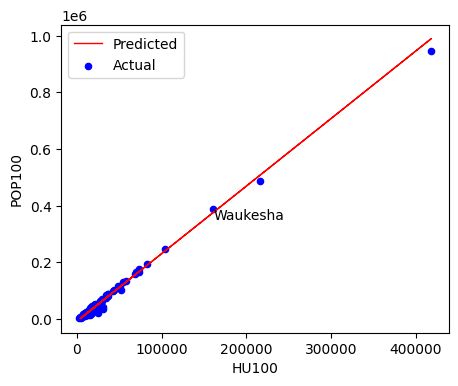

In [23]:
#Q12
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html
# plot
fig, ax = plt.subplots(1,1)
fig.set_size_inches(5,4)
plt.plot(test[["HU100"]], test["pred_POP100"], color="red", linewidth=1)
counties_gpd[['HU100', 'POP100']].plot.scatter('HU100', 'POP100', ax=ax, color="blue", legend=True)
# add legend and annotate
ax.legend(["Predicted", "Actual"], loc='upper left')
wc_x = int(counties_gpd[counties_gpd['NAME'] == 'Waukesha County']['HU100'].values[0])
wc_y = int(counties_gpd[counties_gpd['NAME'] == 'Waukesha County']['POP100'].values[0])
ax.text(wc_x, wc_y, 'Waukesha', horizontalalignment='left', verticalalignment='top')

In [24]:
### Part 3 Land Use Features ###

In [25]:
A = np.array([
    [0,0,5,8,4],
    [1,2,4,0,3],
    [2,4,0,9,2],
    [3,5,2,1,1],
    [0,5,0,1,0]
])

In [26]:
#Q13
int(((A>=1) & (A<=4)).astype(int).sum())

13

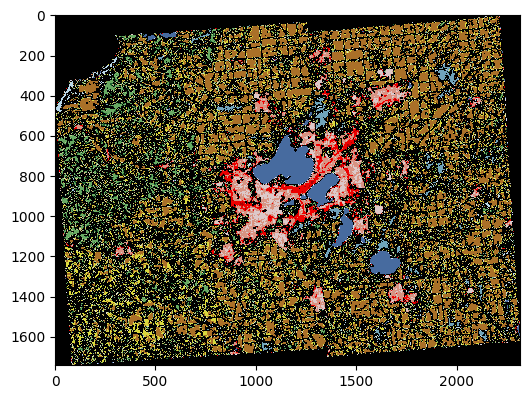

In [27]:
#Q14
land = rasterio.open("zip://./land.zip!wi.tif") # get matrix
df = gpd.read_file("counties.geojson")
dane = df.loc[df['NAME'] == 'Dane County'] # get geometry
#dane.plot() # plot dane county shape

matrix, _ = mask(land, dane.to_crs(land.crs)["geometry"], crop=True) # set mask
matrix = matrix[0] # get dane plottable

c = np.zeros((256,3)) # custom color map
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)

fig, ax = plt.subplots(figsize=(6,6)) # size figure
ax.imshow(matrix, vmin=0, vmax=255, cmap=custom_cmap) # show figure

In [28]:
land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}

crop_cells = (matrix == land_use['crops']).astype(int).sum()
nonzero_cells = (matrix != 0).astype(int).sum()
portion_crop_cells = float(crop_cells / nonzero_cells)

In [29]:
#Q15
portion_crop_cells

0.46705544316564085

In [30]:
counties_gpd["Grassland_Cells"] = 0
i = 0
for name in counties_gpd["NAME"]:
    county_df = df.loc[df['NAME'] == name] # get geometry
    matrix, _ = mask(land, county_df.to_crs(land.crs)["geometry"], crop=True) # set mask
    matrix = matrix[0] # get df plottable
    cells = (matrix == land_use['grassland']).astype(int).sum()
    counties_gpd.loc[i, "Grassland_Cells"] = cells
    i += 1

Text(0.5, 0, 'Grassland Cells in County')

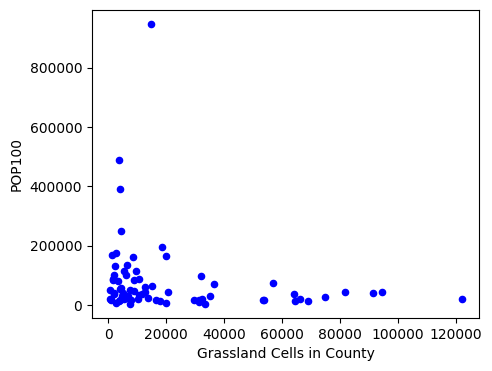

In [31]:
#Q16
fig, ax = plt.subplots(1,1)
fig.set_size_inches(5,4)
counties_gpd[['Grassland_Cells', 'POP100']].plot.scatter('Grassland_Cells', 'POP100', ax=ax, color="blue", legend=True)
ax.set_xlabel("Grassland Cells in County")

In [32]:
# Individual Part

In [33]:
# loading GeoDataFrame and land types dictionary
tracts_gpd = gpd.read_file("tracts.shp")
tracts_df = tracts_gpd[["GEOID","POP100"]]
#tracts_gpd.head(3)


land_types = list(land_use.keys())
for land_type in land_types:
    tracts_df[land_type] = 0

#tracts_gpd.loc[[0]]

In [34]:
# populating feature columns
for i in range(len(tracts_gpd)):
    curr_df = tracts_gpd.loc[[i]] # get current row
    matrix, _ = mask(land, curr_df.to_crs(land.crs)["geometry"], crop=True) # set mask
    matrix = matrix[0] # get matrix array
    
    for land_type in land_types: # calculate num cells for each land type
        cells = (matrix == land_use[land_type]).astype(int).sum()
        tracts_df.loc[i, land_type] = cells

In [35]:
# split GeoDataFrame into train/test dataframes
train, test = train_test_split(tracts_df,random_state=320,test_size=0.20)

features = list(train.columns[2:])

In [36]:
# construct regression model to predict POP100
# use all new columns as features for training.
model = LinearRegression()
# Fit using training data
model.fit(train[features], train["POP100"])
# Predict using test data
predictions = model.predict(test[features])
# We can use score directly as it automatically invokes predict
model.score(test[features], test["POP100"])

0.3870945545628156

In [37]:
# construct dataframe for plotting
plot_df = pd.DataFrame()
plot_df["features"] = features
plot_df["coefs"] = model.coef_

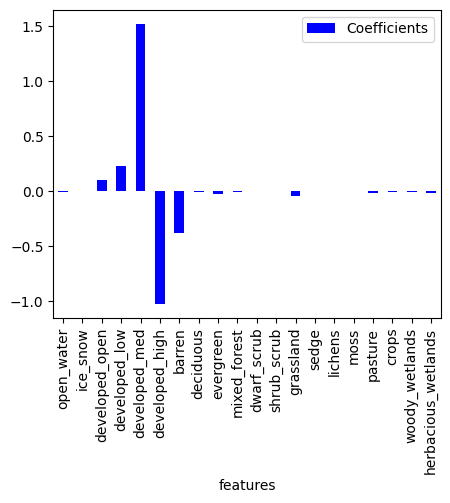

In [38]:
#Q17
# construct ax for plotting and plot
fig, ax = plt.subplots(1,1)
fig.set_size_inches(5,4)
plot_df.plot.bar("features", "coefs", ax=ax, color="blue", legend=True)
ax.legend(["Coefficients"], loc='upper right')
# the bar graph shows the magnitude at which parameters (holding other regression factors constant) increase or decrease POP100
# from this chart, lets run a regression with parameters that have a slope estimator of >= 0.1
# our model_0 is then POP100 = B_0 + B_1developed_open + B_2dev_low + B_3dev_med + B_4dev_high + B_5barren + u

In [39]:
# Part 2

In [40]:
# we will run a regression as detailed in the comment above and also model_1 or regress
# POP100 on developed_med, developed_high, and barren
# if we wanted to go further, we could use model_0 as our unrestricted model and model_1 as restricted model and 
# test for the significance of the variables omitted in the restricted model. but that is outside the scope here.

# could also add in interaction terms or param^2 to allow for non-linear returns to POP100
# in that case I would add in developed_low^2 as I expect this to be suburban houses and wisconsin counties are mostly 
# not highly concentrated city centers.


tracts_df["dev_low2"] = tracts_df["developed_low"] ** 2
train, test = train_test_split(tracts_df,random_state=320,test_size=0.20)

m0_features = list(train.columns[4:9])
m0_features.append("dev_low2")
m1_features = list(train.columns[6:9])

# construct model_0
model_0 = LinearRegression()
# Fit using training data
model_0.fit(train[m0_features], train["POP100"])
# Predict using test data
predictions_m0 = model_0.predict(test[m0_features])
# We can use score directly as it automatically invokes predict
m0_score = model_0.score(test[m0_features], test["POP100"])
m0_cross_vals = cross_val_score(model_0, train[m0_features], train["POP100"])

# construct model_1
model_1 = LinearRegression()
# Fit using training data
model_1.fit(train[m1_features], train["POP100"])
# Predict using test data
predictions_m1 = model_1.predict(test[m1_features])
# We can use score directly as it automatically invokes predict
m1_score = model_1.score(test[m1_features], test["POP100"])
m1_cross_vals = cross_val_score(model_1, train[m1_features], train["POP100"])

print("Model_0 score:", m0_score, "\nModel_1 score:", m1_score)
print("\nModel_0 cross vals:", m0_cross_vals, "\nModel_1 cross vals:", m1_cross_vals)

Model_0 score: 0.42838250239850173 
Model_1 score: 0.3141565632710447

Model_0 cross vals: [0.49345167 0.44103143 0.50376848 0.45843419 0.50586997] 
Model_1 cross vals: [0.4498862  0.38989384 0.47716044 0.41353435 0.48180183]


In [41]:
#Q18
# note, Q18 hint suggests using .std() even though the question asks for the variance.

# model_0: model1 ; model_1: model2
q18_dict = {'model1-avg': float(m0_cross_vals.mean()),
             'model1-std': float(m0_cross_vals.std()),
             'model2-avg': float(m1_cross_vals.mean()),
             'model2-std': float(m1_cross_vals.std())}

# I would use model_0 for this prediction task. the mean of cross validation scores for model_0 is greater than model_1's. 
# in addition, model_0 has a smaller variance which - disregarding concepts like robust std errors and heteroskedasticity - 
# is what we outright prefer. model_0 and model_1 are both relatively simple in terms of parameters. 
#
# if I was using model_0 for production, I would probably add in squared parameters to allow for non-linear returns
# and use a log linear model with Feasible Weighted Least Squares.

q18_dict

{'model1-avg': 0.4805111470946232,
 'model1-std': 0.02606710829024343,
 'model2-avg': 0.44245533241265,
 'model2-std': 0.03579648878023838}

In [42]:
#Q19
# fitted model_0 to train dataset two boxes above.
# also scored model_0 two boxes above.


# explained_variance_score(test['POP100'], predictions_m0) 0.428544
# r2_score(test['POP100'], predictions_m0) 0.428383 - same as above but uses ((y-y_hat) ** 2)
# m0_score = model_0.score(test[m0_features], test["POP100"])- same as above
m0_score

0.42838250239850173